# Predicting Temperature in London

![tower_bridge](tower_bridge.jpg)

As the climate changes, predicting the weather becomes ever more important for businesses. The aim is to support on a machine learning project with the building a pipeline to predict the climate in London, England. Specifically, the model should predict mean temperature in degrees Celsius (°C).

Since the weather depends on a lot of different factors, a lot of experiments to determine what the best approach is to predict the weather is needed. In this project, experiments for different regression models to predict the mean temperature is done by using a combination of `sklearn` and `mlflow`.

The data stored in `london_weather.csv`, which contains the following columns:
- **date** - recorded date of measurement - (**int**)
- **cloud_cover** - cloud cover measurement in oktas - (**float**)
- **sunshine** - sunshine measurement in hours (hrs) - (**float**)
- **global_radiation** - irradiance measurement in Watt per square meter (W/m2) - (**float**)
- **max_temp** - maximum temperature recorded in degrees Celsius (°C) - (**float**)
- **mean_temp** - **target** mean temperature in degrees Celsius (°C) - (**float**)
- **min_temp** - minimum temperature recorded in degrees Celsius (°C) - (**float**)
- **precipitation** - precipitation measurement in millimeters (mm) - (**float**)
- **pressure** - pressure measurement in Pascals (Pa) - (**float**)
- **snow_depth** - snow depth measurement in centimeters (cm) - (**float**)

In [1]:
"""Packages should be installed if needed"""
#!pip install mlflow

'Packages should be installed if needed'

In [2]:
"""Import necessary modules"""
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

### Import the data and perform exploratory data analysis (EDA)

In [3]:
"""Import the data and shows necessary informations"""
weather = pd.read_csv("london_weather.csv")
weather.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              15341 non-null  int64  
 1   cloud_cover       15322 non-null  float64
 2   sunshine          15341 non-null  float64
 3   global_radiation  15322 non-null  float64
 4   max_temp          15335 non-null  float64
 5   mean_temp         15305 non-null  float64
 6   min_temp          15339 non-null  float64
 7   precipitation     15335 non-null  float64
 8   pressure          15337 non-null  float64
 9   snow_depth        13900 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 1.2 MB


In [4]:
"""Cleaning and preparing the data"""
weather["date"] = pd.to_datetime(weather["date"], format="%Y%m%d")
weather["year"] = weather["date"].dt.year
weather['month'] = weather['date'].dt.month
weather_metrics = ['cloud_cover', 'sunshine', 'global_radiation', 'max_temp', 'mean_temp', 'min_temp', 'precipitation', 'pressure', 'snow_depth']
weather_per_month = weather.groupby(['year', 'month'], as_index = False)[weather_metrics].mean()

C:\Users\mohid\AppData\Local\Temp\ipykernel_13152\989176396.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x="year", y="mean_temp", data=weather_per_month, ci=None)


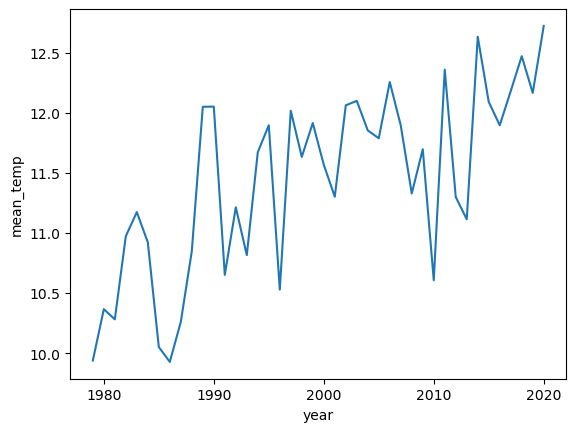

In [7]:
"""Plot a lineplot"""
sns.lineplot(x="year", y="mean_temp", data=weather_per_month, ci=None)
plt.show()

C:\Users\mohid\AppData\Local\Temp\ipykernel_13152\2640604433.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(weather.corr(), annot=True)


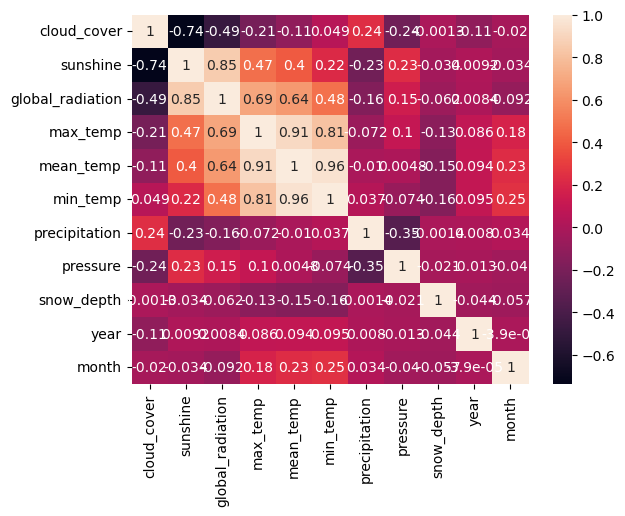

In [8]:
"""Plot heatmap"""
sns.heatmap(weather.corr(), annot=True)
plt.show()

In [9]:
"""Choose features, define the target, and drop null values"""
feature_selection = ['month', 'cloud_cover', 'sunshine', 'precipitation', 'pressure', 'global_radiation']
target_var = 'mean_temp'
weather = weather.dropna(subset=['mean_temp'])

In [10]:
"""Subset feature and target sets"""
X = weather[feature_selection]    
y = weather[target_var]

In [11]:
"""Split the data"""
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [12]:
"""Impute missing values"""
imputer = SimpleImputer(strategy="mean")

In [13]:
"""Fit on the training data"""
X_train = imputer.fit_transform(X_train)

In [14]:
"""Transform on the test data"""
X_test  = imputer.transform(X_test)

In [15]:
"""Scale the data"""
scaler = StandardScaler()

In [16]:
"""Fit on the training data"""
X_train = scaler.fit_transform(X_train)

In [17]:
"""Transform on the test data"""
X_test = scaler.transform(X_test)

In [18]:
"""Predict, evaluate, and log the parameters and metrics of the models"""
for idx, depth in enumerate([1, 2, 5, 10, 20]): 
    run_name = f"run_{idx}"
    with mlflow.start_run(run_name=run_name):
        # Create models
        lin_reg = LinearRegression().fit(X_train, y_train)
        tree_reg = DecisionTreeRegressor(random_state=42, max_depth=depth).fit(X_train, y_train)
        forest_reg = RandomForestRegressor(random_state=42, max_depth=depth).fit(X_train, y_train)
        # Log models
        mlflow.sklearn.log_model(lin_reg, "lin_reg")
        mlflow.sklearn.log_model(tree_reg, "tree_reg")
        mlflow.sklearn.log_model(forest_reg, "forest_reg")
        # Evaluate performance
        y_pred_lin_reg = lin_reg.predict(X_test)
        lin_reg_rmse = mean_squared_error(y_test, y_pred_lin_reg, squared=False)
        y_pred_tree_reg = tree_reg.predict(X_test)
        tree_reg_rmse = mean_squared_error(y_test, y_pred_tree_reg, squared=False)
        y_pred_forest_reg = forest_reg.predict(X_test)
        forest_reg_rmse = mean_squared_error(y_test, y_pred_forest_reg, squared=False)
        # Log performance
        mlflow.log_param("max_depth", depth)
        mlflow.log_metric("rmse_lr", lin_reg_rmse)
        mlflow.log_metric("rmse_tr", tree_reg_rmse)
        mlflow.log_metric("rmse_fr", forest_reg_rmse)

C:\Users\mohid\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [21]:
"""Search the runs for the experiment's results"""
experiment_results = mlflow.search_runs()
experiment_results

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.rmse_tr,metrics.rmse_lr,metrics.rmse_fr,params.max_depth,tags.mlflow.runName,tags.mlflow.log-model.history,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.source.type
0,e990a67ff5754cfb93093f918c23f500,0,FINISHED,file:///C:/Users/mohid/Complete%20Project/Pred...,2023-11-23 18:10:18.034000+00:00,2023-11-23 18:10:38.304000+00:00,3.807963,3.866773,2.893355,20,run_4,"[{""run_id"": ""e990a67ff5754cfb93093f918c23f500""...",mohid,C:\Users\mohid\anaconda3\Lib\site-packages\ipy...,LOCAL
1,dbcc45ef5bee4d23967500e504ee8b5d,0,FINISHED,file:///C:/Users/mohid/Complete%20Project/Pred...,2023-11-23 18:10:02.256000+00:00,2023-11-23 18:10:18.018000+00:00,3.068346,3.866773,2.814782,10,run_3,"[{""run_id"": ""dbcc45ef5bee4d23967500e504ee8b5d""...",mohid,C:\Users\mohid\anaconda3\Lib\site-packages\ipy...,LOCAL
2,cc6071c383b8407ab6210cf7f2da2d4c,0,FINISHED,file:///C:/Users/mohid/Complete%20Project/Pred...,2023-11-23 18:09:47.756000+00:00,2023-11-23 18:10:02.240000+00:00,3.027733,3.866773,2.967462,5,run_2,"[{""run_id"": ""cc6071c383b8407ab6210cf7f2da2d4c""...",mohid,C:\Users\mohid\anaconda3\Lib\site-packages\ipy...,LOCAL
3,74ebc090d09c46a181e20d2a373cc800,0,FINISHED,file:///C:/Users/mohid/Complete%20Project/Pred...,2023-11-23 18:09:34.260000+00:00,2023-11-23 18:09:47.741000+00:00,3.917318,3.866773,3.832143,2,run_1,"[{""run_id"": ""74ebc090d09c46a181e20d2a373cc800""...",mohid,C:\Users\mohid\anaconda3\Lib\site-packages\ipy...,LOCAL
4,4702b21d70b14e568699729d6d43dbd4,0,FINISHED,file:///C:/Users/mohid/Complete%20Project/Pred...,2023-11-23 18:09:19.471000+00:00,2023-11-23 18:09:34.244000+00:00,4.752035,3.866773,4.694655,1,run_0,"[{""run_id"": ""4702b21d70b14e568699729d6d43dbd4""...",mohid,C:\Users\mohid\anaconda3\Lib\site-packages\ipy...,LOCAL
5,2016fcbee7db4cec8603a372e98d9289,0,FINISHED,file:///C:/Users/mohid/Complete%20Project/Pred...,2023-11-10 22:47:29.734000+00:00,2023-11-10 22:47:49.122000+00:00,3.807963,3.866773,2.893355,20,run_4,"[{""run_id"": ""2016fcbee7db4cec8603a372e98d9289""...",mohid,C:\Users\mohid\anaconda3\Lib\site-packages\ipy...,LOCAL
6,b0a279d2bc0046fd976671e707ac43fb,0,FINISHED,file:///C:/Users/mohid/Complete%20Project/Pred...,2023-11-10 22:47:13.137000+00:00,2023-11-10 22:47:29.726000+00:00,3.068346,3.866773,2.814782,10,run_3,"[{""run_id"": ""b0a279d2bc0046fd976671e707ac43fb""...",mohid,C:\Users\mohid\anaconda3\Lib\site-packages\ipy...,LOCAL
7,9c8790db0cc94ee08e72db00243161d0,0,FINISHED,file:///C:/Users/mohid/Complete%20Project/Pred...,2023-11-10 22:46:57.494000+00:00,2023-11-10 22:47:13.121000+00:00,3.027733,3.866773,2.967462,5,run_2,"[{""run_id"": ""9c8790db0cc94ee08e72db00243161d0""...",mohid,C:\Users\mohid\anaconda3\Lib\site-packages\ipy...,LOCAL
8,ff850f7640e947a08e349bd2535c9509,0,FINISHED,file:///C:/Users/mohid/Complete%20Project/Pred...,2023-11-10 22:46:43.643000+00:00,2023-11-10 22:46:57.478000+00:00,3.917318,3.866773,3.832143,2,run_1,"[{""run_id"": ""ff850f7640e947a08e349bd2535c9509""...",mohid,C:\Users\mohid\anaconda3\Lib\site-packages\ipy...,LOCAL
9,d26abdb6cbbe4b14bbffa682d14e1ed3,0,FINISHED,file:///C:/Users/mohid/Complete%20Project/Pred...,2023-11-10 22:46:28.649000+00:00,2023-11-10 22:46:43.620000+00:00,4.752035,3.866773,4.694655,1,run_0,"[{""run_id"": ""d26abdb6cbbe4b14bbffa682d14e1ed3""...",mohid,C:\Users\mohid\anaconda3\Lib\site-packages\ipy...,LOCAL
